In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlite3
from datetime import date, timedelta
import matplotlib.pyplot as plt

In [3]:
# Koneksi ke database
conn = sqlite3.connect("/content/drive/MyDrive/olist.db")
cur = conn.cursor()

In [4]:
# Menjalankan koneksi dan mengambil seluruh table database
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('olist_order_customer_dataset',), ('olist_order_dataset',), ('olist_order_reviews_dataset',), ('olist_order_payments_dataset',), ('olist_order_items_dataset',), ('olist_products_dataset',), ('olist_sellers_dataset',), ('olist_geolocation_dataset',), ('product_category_name_translation',)]


In [5]:
# Ubah kedalam dataframe pandas
df_products = pd.read_sql("SELECT * FROM olist_products_dataset", conn)
df_order_customer = pd.read_sql("SELECT * FROM olist_order_customer_dataset", conn)
df_order = pd.read_sql("SELECT * FROM olist_order_dataset", conn)
df_order_reviews = pd.read_sql("SELECT * FROM olist_order_reviews_dataset", conn)
df_order_payments = pd.read_sql("SELECT * FROM olist_order_payments_dataset", conn)
df_order_items = pd.read_sql("SELECT * FROM olist_order_items_dataset", conn)
df_sellers = pd.read_sql("SELECT * FROM olist_sellers_dataset", conn)
df_geolocation = pd.read_sql("SELECT * FROM olist_geolocation_dataset", conn)
df_translations = pd.read_sql("SELECT * FROM product_category_name_translation", conn)

In [6]:
# Ambil dataframes yang dibutuhkan
data_merged = df_products.merge(df_translations, on='product_category_name')
data_merged = data_merged.merge(df_order_items, on='product_id', )
data_merged = data_merged.merge(df_order, on='order_id',)
data_merged = data_merged.merge(df_order_customer, on='customer_id')
data_merged = data_merged.merge(df_sellers, on='seller_id')
data_merged = data_merged.merge(df_order_payments, on='order_id')

<ipython-input-6-a52266265fa9>:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'index_x'} in the result is deprecated and will raise a MergeError in a future version.
  data_merged = data_merged.merge(df_order, on='order_id',)
<ipython-input-6-a52266265fa9>:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'index_x'} in the result is deprecated and will raise a MergeError in a future version.
  data_merged = data_merged.merge(df_sellers, on='seller_id')


In [7]:
data_merged.head()

,index_x,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,...,customer_state,index_y,seller_zip_code_prefix,seller_city,seller_state,index,payment_sequential,payment_type,payment_installments,payment_value
0,0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,...,SP,438,3694,sao paulo,SP,23321,1,debit_card,1,18.30
1,4540,a035b83b3628decee6e3823924e0c10f,perfumaria,53.0,2235.0,3.0,1450.0,20.0,25.0,20.0,...,PR,438,3694,sao paulo,SP,67995,1,credit_card,10,289.45
2,11970,091107484dd7172f5dcfed173e4a960e,perfumaria,50.0,260.0,2.0,183.0,16.0,8.0,13.0,...,SP,438,3694,sao paulo,SP,101584,1,credit_card,2,57.75
3,31443,e8b61f78db501ea0ca45677d1ca27de2,brinquedos,49.0,120.0,1.0,400.0,50.0,10.0,25.0,...,SP,2345,13232,campo limpo paulista,SP,101584,1,credit_card,2,57.75
4,14590,ccac9976bafbf7e587bd2c29302e2314,perfumaria,53.0,2235.0,3.0,1500.0,20.0,25.0,20.0,...,DF,438,3694,sao paulo,SP,39010,1,credit_card,8,286.45


In [13]:
data_merged.shape

(115878, 41)

In [14]:
# Buang data yang tidak diperlukan
data_filtered = data_merged.drop(columns=['product_photos_qty','product_name_lenght','product_description_lenght'
                                      ,'product_photos_qty','product_weight_g'
                                      ,'product_length_cm','product_length_cm','product_width_cm','product_height_cm'
                                      ,'freight_value','customer_zip_code_prefix'
                                      ])

In [15]:
data_filtered.shape

(115878, 32)

### Data Cleansing

1.  Clean Missing Values



In [11]:
pd.set_option('display.max_rows', len(data_merged.columns))

In [16]:
# Mencari jumlah missing value dan mengurutkan secera descending
nan_col = data_filtered.isna().sum().sort_values(ascending = False)
nan_col

# menghitung persentase missing value pada tiap kolom
n_data = len(data_filtered)

percent_nan_col = (nan_col/n_data) * 100
percent_nan_col

order_delivered_customer_date    2.153127
order_delivered_carrier_date     1.039887
order_approved_at                0.012082
payment_installments             0.000000
payment_type                     0.000000
payment_sequential               0.000000
index                            0.000000
seller_state                     0.000000
seller_city                      0.000000
seller_zip_code_prefix           0.000000
index_y                          0.000000
customer_state                   0.000000
customer_city                    0.000000
customer_unique_id               0.000000
index_x                          0.000000
order_estimated_delivery_date    0.000000
index_x                          0.000000
product_id                       0.000000
order_purchase_timestamp         0.000000
order_status                     0.000000
customer_id                      0.000000
index_y                          0.000000
price                            0.000000
shipping_limit_date              0

In [17]:
# Buang missing value karena persentase dibawah 3%
data_clean = data_filtered.dropna()

# Mengecek kembali data
check_na = data_clean.isna().sum() / len(data_clean) * 100
check_na

index_x                          0.0
product_id                       0.0
product_category_name            0.0
index_y                          0.0
product_category_name_english    0.0
index_x                          0.0
order_id                         0.0
order_item_id                    0.0
seller_id                        0.0
shipping_limit_date              0.0
price                            0.0
index_y                          0.0
customer_id                      0.0
order_status                     0.0
order_purchase_timestamp         0.0
order_approved_at                0.0
order_delivered_carrier_date     0.0
order_delivered_customer_date    0.0
order_estimated_delivery_date    0.0
index_x                          0.0
customer_unique_id               0.0
customer_city                    0.0
customer_state                   0.0
index_y                          0.0
seller_zip_code_prefix           0.0
seller_city                      0.0
seller_state                     0.0
i

In [18]:
data_clean.shape

(113368, 32)



2. Handling Duplicates



In [19]:

# Mengecek adanya duplikasi
data_clean[data_clean.duplicated(keep=False)]

,index_x,product_id,product_category_name,index_y,product_category_name_english,index_x,order_id,order_item_id,seller_id,shipping_limit_date,...,customer_state,index_y,seller_zip_code_prefix,seller_city,seller_state,index,payment_sequential,payment_type,payment_installments,payment_value


3. Check Inconsistency

In [20]:
# Mengecek inkonsistensi format
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113368 entries, 0 to 115877
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   index_x                        113368 non-null  int64  
 1   product_id                     113368 non-null  object 
 2   product_category_name          113368 non-null  object 
 3   index_y                        113368 non-null  int64  
 4   product_category_name_english  113368 non-null  object 
 5   index_x                        113368 non-null  int64  
 6   order_id                       113368 non-null  object 
 7   order_item_id                  113368 non-null  int64  
 8   seller_id                      113368 non-null  object 
 9   shipping_limit_date            113368 non-null  object 
 10  price                          113368 non-null  float64
 11  index_y                        113368 non-null  int64  
 12  customer_id                   

### Data Analysis


In [21]:
#1. Melihat jumlah order terbanyak
most_order = data_clean.groupby(['product_category_name_english']).agg({'order_id':'count'}).sort_values(by='order_id', ascending=False).head(10)
most_order = most_order.reset_index()
most_order

,product_category_name_english,order_id
0,bed_bath_table,11649
1,health_beauty,9761
2,sports_leisure,8731
3,furniture_decor,8553
4,computers_accessories,7897
5,housewares,7172
6,watches_gifts,6063
7,telephony,4601
8,garden_tools,4463
9,auto,4283


Text(0.5, 0, 'Total (orders)')

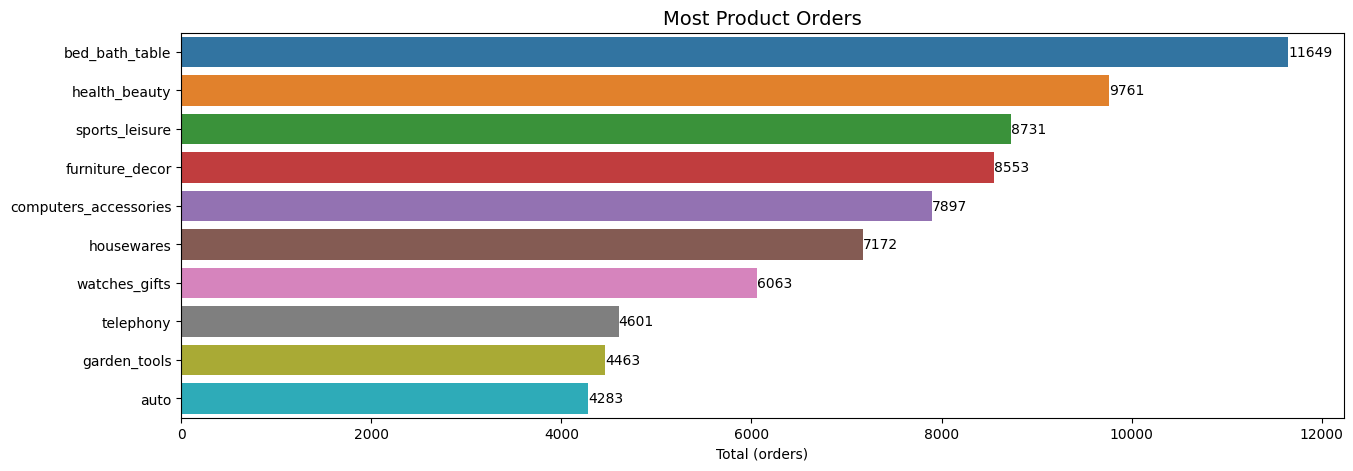

In [22]:
plt.figure(figsize=(15,5))
ax = sns.barplot(y='product_category_name_english',
           x="order_id",
           data=most_order)
for i in ax.containers:
    ax.bar_label(i,)

# Title and label
ax.set_title('Most Product Orders', fontsize=14)
ax.set_ylabel('')
ax.set_xlabel('Total (orders)', fontsize=10)

In [24]:
# Total penjualan per category
sales_category = data_clean.groupby(['product_category_name_english']).agg(count = ('order_id','count'), total_sales =('price','sum')).sort_values(by='total_sales', ascending=False).head(10)
sales_category

,count,total_sales
product_category_name_english,,
health_beauty,9761,1271413.18
watches_gifts,6063,1213162.80
bed_bath_table,11649,1077834.14
sports_leisure,8731,990417.74
computers_accessories,7897,918837.87
furniture_decor,8553,745748.80
housewares,7172,648187.74
cool_stuff,3904,634163.78
auto,4283,602881.75


Text(0.5, 0, 'Total Sales(in millions)')

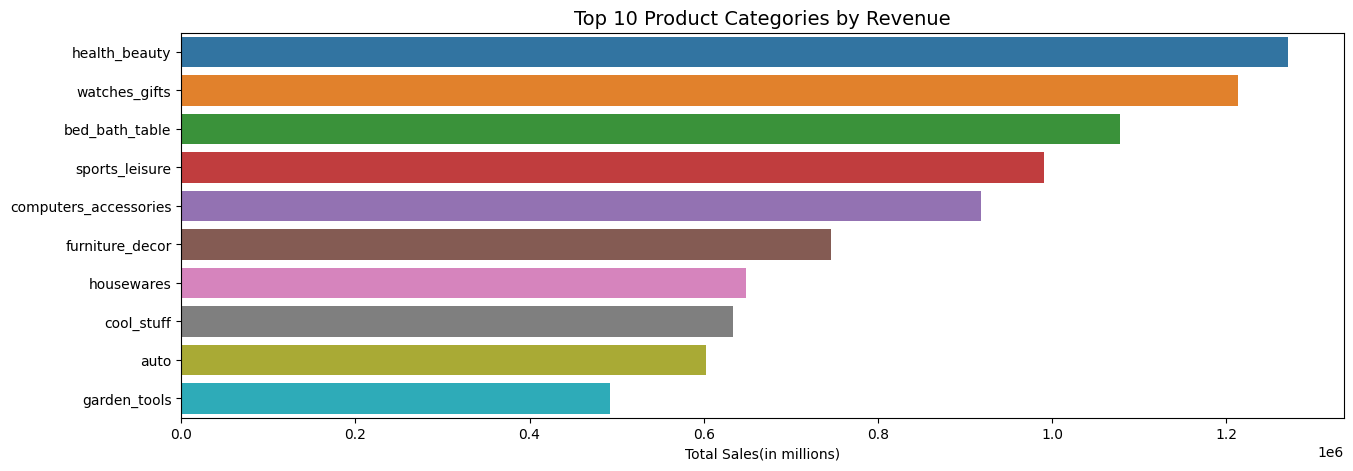

In [25]:
#visualisasi data
plt.figure(figsize=(15,5))
ax = sns.barplot(y=sales_category.index,
           x="total_sales",
           data=sales_category)


ax.set_title('Top 10 Product Categories by Revenue', fontsize=14)
ax.set_ylabel('')
ax.set_xlabel('Total Sales(in millions)', fontsize=10)

In [26]:
# Tipe Pembayaran Pengguna
payment_counts = data_clean.groupby('payment_type')['order_id'].count()
print(payment_counts)

payment_type
boleto         22040
credit_card    83696
debit_card      1621
voucher         6011
Name: order_id, dtype: int64


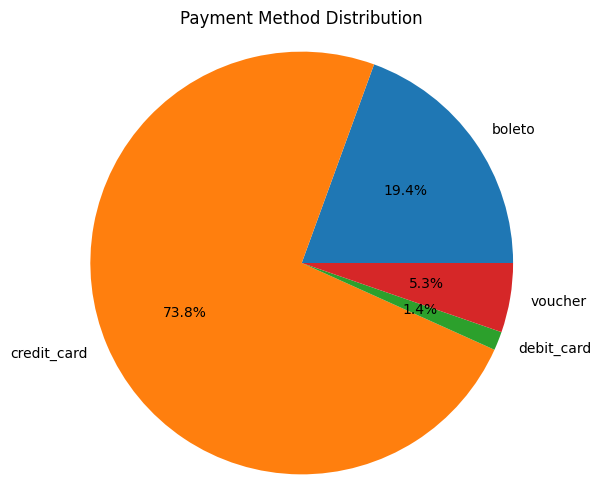

In [31]:
plt.figure(figsize=(6, 6))
label_distance = 2.05
plt.pie(payment_counts, labels=payment_counts.index, autopct='%1.1f%%')
plt.title('Payment Method Distribution')
plt.axis('equal')

# Show the pie chart
plt.show()

In [36]:
# Kota Pelanggan Terbanyak
top_order_city = data_clean.groupby(['customer_city']).agg(total_orders = ('order_id','count')).sort_values(by='total_orders', ascending=False).head(10)
top_order_city

,total_orders
customer_city,
sao paulo,17867
rio de janeiro,7821
belo horizonte,3133
brasilia,2374
curitiba,1768
campinas,1686
porto alegre,1589
salvador,1435
guarulhos,1347


Text(0.5, 0, 'City')

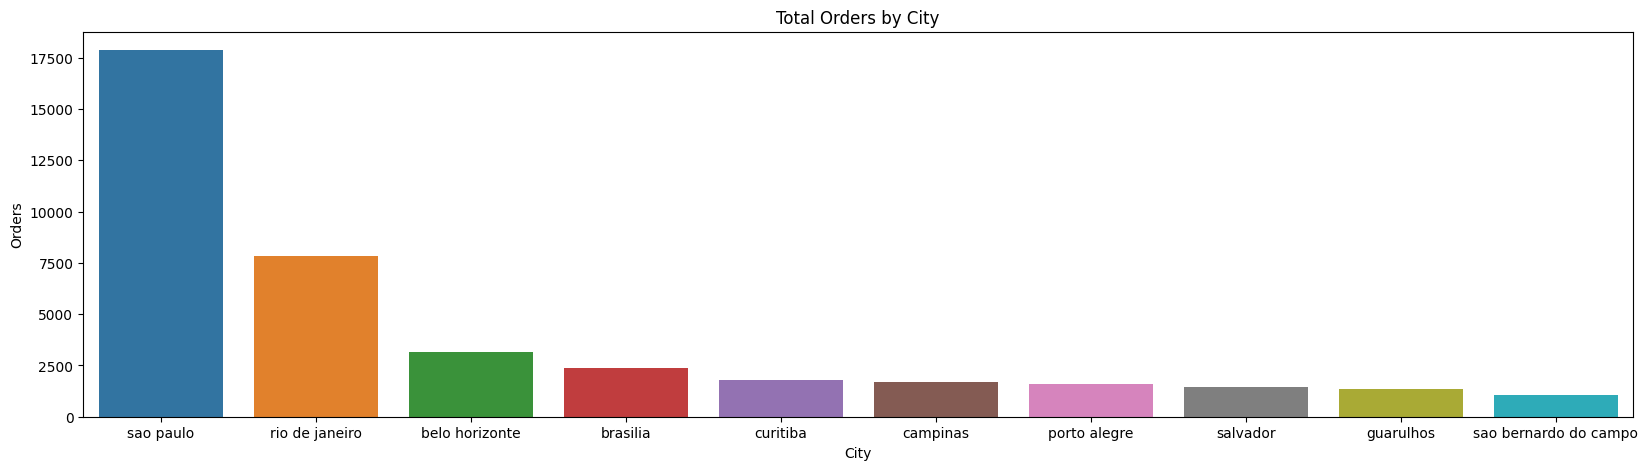

In [41]:
plt.figure(figsize=(20,5))
ax = sns.barplot(y='total_orders',
           x=top_order_city.index,
           data=top_order_city)

# Title and label
ax.set_title('Total Orders by City', fontsize=12)
ax.set_ylabel('Orders')
ax.set_xlabel('City', fontsize=10)